In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
source("likelihoodFunctionCC.R")
source("TADAaddEvidence.R")
mu.frac <- c(0.074, 0.32)
gamma.mean.dn <- c(20, 4.7)
beta.dn <- c(1,1)
gamma.mean.CC <- c(2.3, 1.00)
beta.CC <- c(4.0, 1000)
rho1 <- c(0.1, 0.5)
nu1 <- c(200, 100)
rho0 <- c(0.1, 0.5)
nu0 <- c(200, 100)
hyperpar <- as.array(rbind(gamma.mean.dn, beta.dn, gamma.mean.CC, beta.CC, rho1, nu1, rho0, nu0))
l <- 100
pi0 <- 0.94 # the fraction of non-risk genes

# ASC (Autism Sequencing Consortium) data
# The file name contains the sample size information
# The only relevant counts are dn.LoF and dn.mis3
data <- read.csv("TADA/data/ASC_2231trios_1333trans_1601cases_5397controls.csv", header=TRUE, as.is=TRUE)
ntrio <- 2231  # number of trios
ncase <- 1601  # number of cases
nctrl <- 5397  # number of controls
ntrans <- 1333 # number of subjects with transmission data
N <- list(dn=ntrio, ca=ntrans+ncase, cn=ntrans+nctrl)

# Running TADA
counts <- as.array(cbind(data$dn.LoF, data$case.LoF+data$trans.LoF, data$ctrl.LoF+data$ntrans.LoF, data$dn.mis3, data$case.mis3+data$trans.mis3,
 data$ctrl.mis3+data$ntrans.mis3))


count.mu.Data <- cbind(counts[, 1:3], data$mut.rate*mu.frac[1])
#count.mu.Data <- cbind(counts[, 4:6], data$mut.rate*mu.frac[2])

########Calculate data.frame and likelihood function
##countData should be a data.frame including all annotation types.
#Each type includes 3 columns: de novo, case and control
#mutData: a data.frame including mutation rates of each type


###Re-write the likelihood function

In [3]:
%%R
logLikelihood <- function(countData, hyperpar, pi0 = 0.06, mutationData,
                          testType = c("dn", "cc", "both"), nCore = 1, combinationType = 1){
    ##Identify how many annotation types
    if (is.numeric(mutationData))
        mutationData <- cbind(mutationData)
    kk <- dim(mutationData)[2]

        ###Choose only de novo (dn), only cc (cc), or both ("both")
        testType <- match.arg(testType)
        
    dataOut <- NULL

    logLLKallType <- 0
    
    for (jj in 1:kk){

        ##Extract each annotation
        sIndex <- 3*(jj - 1) + 1
        
        countData.type <- cbind(countData[, c(sIndex, sIndex + 1, sIndex + 2)], mutationData[, jj])

#        print(dim(countData.type))
        
        typeData <- apply(countData.type, 1, function(xRow){
            x <- list(dn = xRow[1],
                    ca = xRow[2], cn = xRow[3], mu = xRow[4])

 #           print(xRow)
                #####Alternative hypothesis
                x.alt.CC <- evidence.alt.CC(x = x, N = N, gamma.mean = hyperpar[3, jj],
                                            beta = hyperpar[4, jj],
                                            rho1 = hyperpar[5, jj], nu1 = hyperpar[6, jj])$total

                x.alt.dn <- dnbinom(x = x$dn, hyperpar[1, jj]*hyperpar[2, jj],
                                   hyperpar[2, jj]/(hyperpar[2, jj] + 2*N$dn*x$mu)) 
                    #evidence.alt.dn(x = xRow[1], N = N$dn, mu = xRow[4],
                     #                       gamma.mean = hyperpar[1, 1], beta = hyperpar[2, 1])

#####Null hypothesis

                x.null.CC <- evidence.null.CC(x = x, N = N, rho0 = hyperpar[7, jj], nu0 = hyperpar[8, jj])$total
                x.null.dn <- dpois(x$dn, 2*N$dn*x$mu) #evidence.null.dn(x = xRow[1], N = N$dn, mu = xRow[4])


            return(c(x.alt.CC, x.alt.dn, x.null.CC, x.null.dn))

        })

        #########Done

        ##############################################
                    ##########Calculate log likelihood
        typeData <- t(typeData)
        
            pH1.dn <- typeData[, 2]
            pH0.dn <- typeData[, 4]

        pH1.cc <- typeData[, 1]
        pH0.cc <- typeData[, 3]
        
        if (testType == "dn"){
            pH1 <- pi0*pH1.dn
            pH0 <- (1 - pi0)*pH0.dn
        } else if (testType == "cc"){
            pH1 <- pi0*pH1.cc
            pH0 <- (1 - pi0)*pH0.cc
        }
        else {
            pH1 <- pi0*pH1.cc*pH1.dn
            pH0 <- (1- pi0)*pH0.cc*pH0.dn
        }
            pAll <- pH1 + pH0

            #sum(log(pAll))

            log.pAll <- sum(log(pAll[!is.na(pAll)]))#log(prod(pAll))


        dataOut <- cbind(dataOut, typeData)
        
            logLLKallType <- logLLKallType + log.pAll

        
    }


    return(list(dataOut = dataOut, logLik = logLLKallType))
}



###Likelihood for de novo LoF only

In [4]:
%%R
piSeq <- seq(0.001, 0.07, 0.002)
library('parallel')

llkout <- lapply(piSeq, function(piX) logLikelihood(countData = counts, hyperpar = hyperpar,
                                      pi0 = piX, mutationData = data$mut.rate*mu.frac[1], 
                                                   testType = "dn")$logLik)
                 


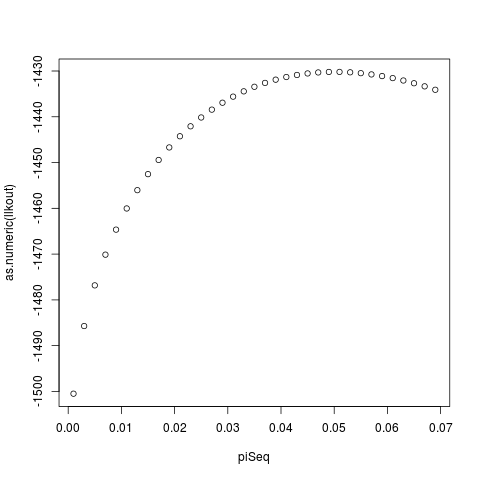

In [5]:
%%R
llkout
plot(piSeq, as.numeric(llkout))



In [6]:
%%R
piSeq <- seq(0.001, 0.07, 0.002)
library('parallel')

hyper1 <- hyperpar
hyper1[1, 1] <- 10

llkout2 <- lapply(piSeq, function(piX) logLikelihood(countData = counts, hyperpar = hyper1,
                                      pi0 = piX, mutationData = data$mut.rate*mu.frac[1], 
                                                   testType = "dn")$logLik)
                 


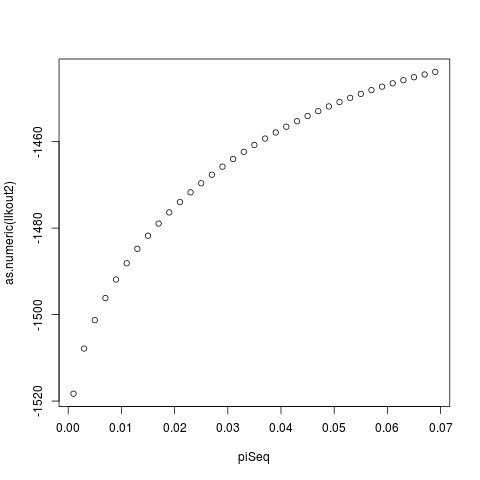

In [7]:
%%R
llkout
plot(piSeq, as.numeric(llkout2))



In [19]:
%%R
piSeq.cc <- seq(0.000001, 0.0001, 0.000002)


llkout.cc <- lapply(piSeq.cc, function(piX) logLikelihood(countData = counts, hyperpar = hyperpar,
                                      pi0 = piX, mutationData = data$mut.rate*mu.frac[1], 
                                                   testType = "cc")$logLik)
                 


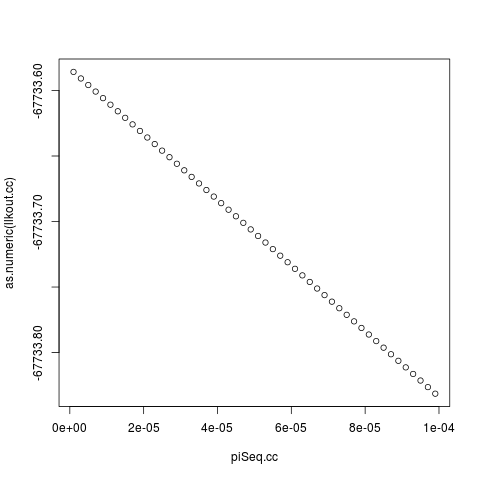

In [20]:
%%R
plot(piSeq.cc, as.numeric(llkout.cc))

###Cannnot see the optimal point for case-control data, use an analytic way

####Write a function to calculate the optimal values

In [23]:
%%R

piFunc.cc <- function(x){

    piX <- x[1]
    
    hyperparNew <- hyperpar
    
    log.All <- -logLikelihood(countData = counts, hyperpar = hyperparNew,
                              pi0 = piX,
                              mutationData = mutationData,
                              testType = "cc")$logLik
    return(log.All)
}


In [24]:
%%R
mutationData <- data$mut.rate*mu.frac[1]
pi.M.cc <- optimize(f = piFunc.cc, interval = c(0, 1))

In [25]:
%%R
pi.M.cc

$minimum
[1] 6.610696e-05

$objective
[1] 67733.75



In [40]:
%%R

tt <- pi.M.cc$minimum
piSeq.cc <- seq(0.000001, 0.0001, by = 0.000005)


llkout.cc <- lapply(piSeq.cc, function(piX) logLikelihood(countData = counts, hyperpar = hyperpar,
                                      pi0 = piX, mutationData = data$mut.rate*mu.frac[1], 
                                                   testType = "cc")$logLik)
                 

In [41]:
%%R
piSeq.cc

 [1] 1.0e-06 6.0e-06 1.1e-05 1.6e-05 2.1e-05 2.6e-05 3.1e-05 3.6e-05 4.1e-05
[10] 4.6e-05 5.1e-05 5.6e-05 6.1e-05 6.6e-05 7.1e-05 7.6e-05 8.1e-05 8.6e-05
[19] 9.1e-05 9.6e-05


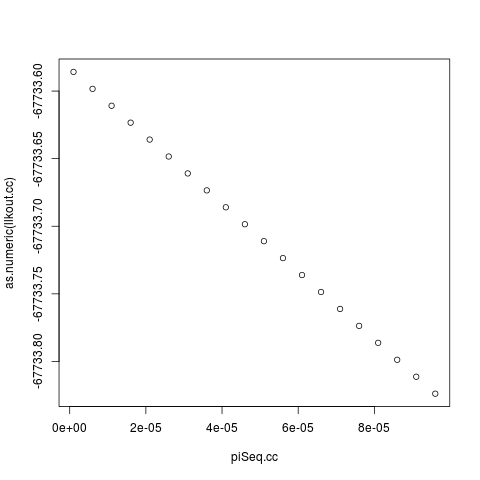

In [42]:
%%R
plot(piSeq.cc, as.numeric(llkout.cc))

###Combine case-control data

In [21]:
%%R
library('parallel')
piSeq1 <- seq(0.00001, 0.015, 0.0002)


llkout.cc <- mclapply(piSeq1, function(piX) logLikelihood(countData = counts, hyperpar = hyperpar,
                                      pi0 = piX, mutationData = data$mut.rate*mu.frac[1], 
                                                        testType = "both")$logLik)
                 



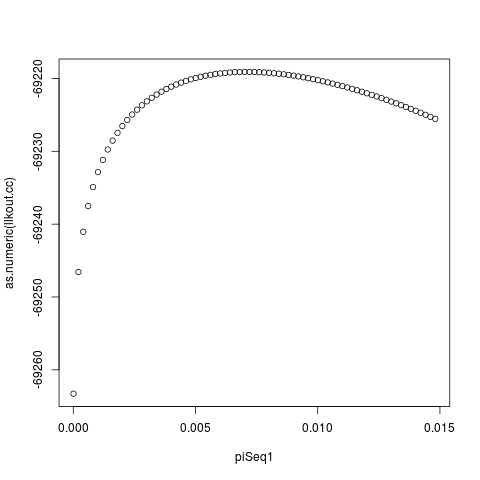

In [22]:
%%R
plot(piSeq1, as.numeric(llkout.cc))

###Write a function to calculate optimal values

In [58]:
%%R
#mutationData <- cbind(data$mut.rate*mu.frac[1])
mutationData <- cbind(data$mut.rate*mu.frac[1], data$mut.rate*mu.frac[2])

piFunc <- function(x){

    piX <- x[1]
    gamma.mean.dn.lof <- x[2]
    beta.dn.lof <- x[3]
    gamma.mean.dn.mis3 <- x[4]
    beta.dn.mis3 <- x[5]

    hyperparNew <- hyperpar
    hyperparNew[1, 1] <- gamma.mean.dn.lof
    hyperparNew[1, 2] <- gamma.mean.dn.mis3
    hyperparNew[2, 1] <- beta.dn.lof
    hyperparNew[2, 2] <- beta.dn.mis3

    log.All <- -logLikelihood(countData = counts, hyperpar = hyperparNew,
                                      pi0 = piX, mutationData = mutationData)$logLik
    return(log.All)
}

#R -e "install.packages(c('rjags'), repos='http://cran.rstudio.com/')"

###Optimize to obtain local optimization values for de novo data of LoF and mis3

In [19]:
%%R
library("optimx")
pi.M <- optimx(c(0.05, 20, 1, 5, 1), fn = piFunc,
               lower = c(0,   5, 0.01,   1, 0.01),
               upper = c(1, 100, 5.00, 100, 5.00))



In [20]:
%%R
pi.M

                 p1       p2         p3       p4 p5    value fevals gevals
L-BFGS-B 0.06362857 16.22064 0.04746113 5.043086  5 4502.795     56     56
         niter convcode kkt1 kkt2   xtimes
L-BFGS-B    NA        0 TRUE TRUE 8523.804


###Take a look at these gamma values

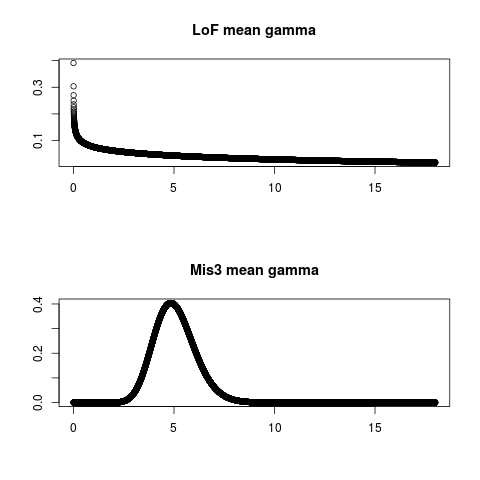

In [72]:
%%R
xGamma <- seq(0.001, 18, 0.002)
par(mfrow = c(2, 1))
plot(xGamma, dgamma(xGamma, 16.22064*0.04746113, rate = 0.04746113), main = 'LoF mean gamma', xlab = '', 
    ylab = '')
###Mis3 de novo
plot(xGamma, dgamma(xGamma, 5.043086*5, rate = 5), main = 'Mis3 mean gamma', xlab = '', ylab = '')


In [59]:
%%R
library("optimx")
pi.M.n <- optimx(c(0.05, 20, 1, 5, 1), fn = piFunc,
               lower = c(0,   5, 1,   1, 1),
               upper = c(1, 100, 5.00, 100, 1000))




#### Set a larger lower limit for beta => small pi

=> Number of risk genes = 32

In [60]:
%%R
pi.M.n

                 p1       p2 p3       p4       p5    value fevals gevals niter
L-BFGS-B 0.03894098 26.85295  1 6.605005 7.968401 4508.279     27     27    NA
         convcode kkt1  kkt2  xtimes
L-BFGS-B        0 TRUE FALSE 3415.53


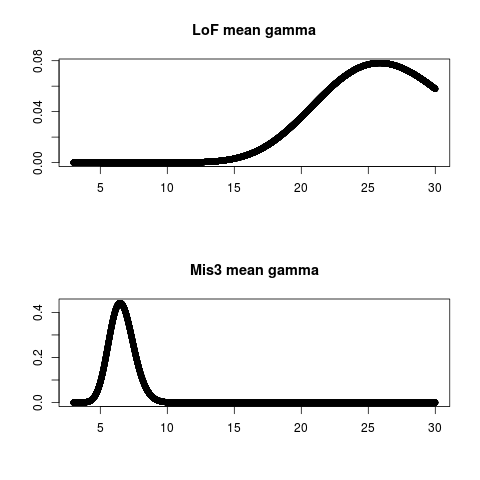

In [75]:
%%R
xGamma <- seq(3, 30, 0.002)
par(mfrow = c(2, 1))
plot(xGamma, dgamma(xGamma, 26.85295, rate =  1 ), main = 'LoF mean gamma', xlab = '', 
    ylab = '')
###Mis3 de novo
plot(xGamma, dgamma(xGamma, 6.605005*7.968401, rate = 7.968401), main = 'Mis3 mean gamma', xlab = '', ylab = '')



In [45]:
%%R
hyperpar

               [,1]   [,2]
gamma.mean.dn  20.0    4.7
beta.dn         1.0    1.0
gamma.mean.CC   2.3    1.0
beta.CC         4.0 1000.0
rho1            0.1    0.5
nu1           200.0  100.0
rho0            0.1    0.5
nu0           200.0  100.0


In [97]:
%%R
#mutationData <- cbind(data$mut.rate*mu.frac[1])
mutationData <- cbind(data$mut.rate*mu.frac[1], data$mut.rate*mu.frac[2])

piFunc.both <- function(x){

    piX <- x[1]
    
    ###De novo
    gamma.mean.dn.lof <- x[2]
    beta.dn.lof <- x[3]
    gamma.mean.dn.mis3 <- x[4]
    beta.dn.mis3 <- x[5]
    
    ###Case-control
    gamma.mean.cc.lof <- x[6]
    beta.cc.lof <- x[7]
    gamma.mean.cc.mis3 <- x[8]
    beta.cc.mis3 <- x[9]

    hyperparNew <- hyperpar
    hyperparNew[1, 1] <- gamma.mean.dn.lof
    hyperparNew[1, 2] <- gamma.mean.dn.mis3
    hyperparNew[2, 1] <- beta.dn.lof
    hyperparNew[2, 2] <- beta.dn.mis3
    
    hyperparNew[3, 1] <- gamma.mean.cc.lof
    hyperparNew[3, 2] <- gamma.mean.cc.mis3
    hyperparNew[4, 1] <- beta.cc.lof
    hyperparNew[4, 2] <- beta.cc.mis3

    log.All <- -logLikelihood(countData = counts, hyperpar = hyperparNew,
                                      pi0 = piX, 
                              testType = "both",
                              mutationData = mutationData)$logLik
    return(log.All)
}



In [98]:
%%R
library("optimx")
pi.M.both <- optimx(c(0.05, 
                      20, 1, 5, 1, 
                     2.3, 4, 1, 100), 
                    
                    fn = piFunc.both,
                    
               lower = c(0,   
                         5, 0.01,   1, 0.01,
                        1, 0.01, 1, 0.01),
               upper = c(1, 
                         100, 5.00, 100, 5.00,
                        100, Inf, 100, Inf))



In [99]:
%%R
pi.M.both

                 p1       p2         p3       p4        p5       p6       p7 p8
L-BFGS-B 0.01406589 20.63603 0.02715622 6.122202 0.9814767 1.023615 3.425842  1
               p9    value fevals gevals niter convcode kkt1  kkt2  xtimes
L-BFGS-B 99.90103 183062.1     18     18    NA        0 TRUE FALSE 4123.83


In [100]:
%%R
library("optimx")
pi.M.both.n <- optimx(c(0.05, 
                      20, 1, 5, 1, 
                     2.3, 4, 1, 100), 
                    
                    fn = piFunc.both,
                    
               lower = c(0,   
                         5, 1, 1, 1,
                         1, 1, 1, 1),
               upper = c(1, 
                         100, 5.00, 100, 5.00,
                        100, Inf, 100, Inf))



In [101]:
#!gist -p Re_test_all_parameters_inTADA.ipynb

In [102]:
%%R
pi.M.both.n

                 p1       p2 p3       p4 p5 p6       p7 p8       p9    value
L-BFGS-B 0.01630855 20.64771  1 6.142555  1  1 3.415442  1 99.89923 183071.6
         fevals gevals niter convcode kkt1  kkt2 xtimes
L-BFGS-B     11     11    NA        0 TRUE FALSE   2422


LoF protective proportion: 0
Mis3 protective proportion: 0.513475935828877


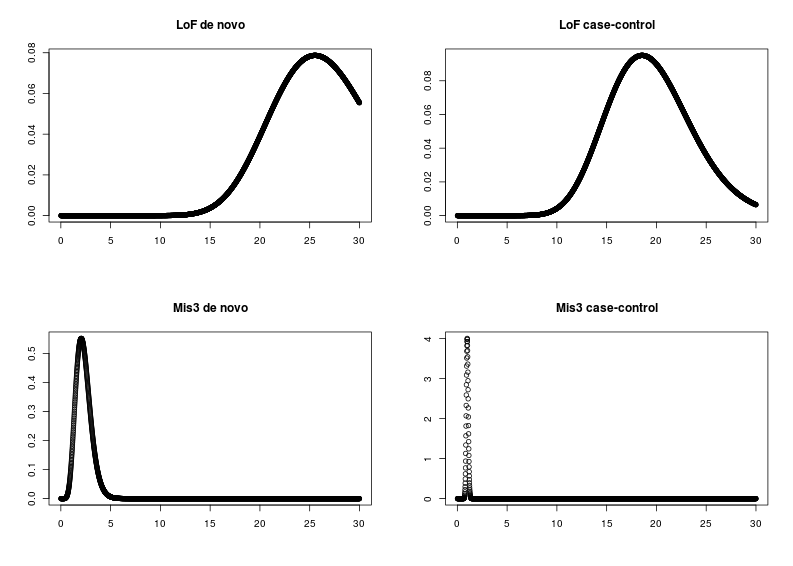

In [103]:
%%R -w 28 -h 20 -u cm
xT <- seq(0.01, 30, 0.01)
par(mfrow = c(2, 2))

plot(xT, dgamma(xT, 26.53*1, rate = 1), main = 'LoF de novo', xlab  = '', ylab = '')
plot(xT, dgamma(xT, 19.5*1.0627, rate = 1.0627), main = 'LoF case-control', xlab  = '', ylab = '')
plot(xT, dgamma(xT, 2.3*4, rate = 4), main = 'Mis3 de novo', xlab  = '', ylab = '')
plot(xT, dgamma(xT, 1*100, rate = 100), main = 'Mis3 case-control', xlab  = '', ylab = '')

NN <- 18700
x.cc.lof <- rgamma(NN, 19.44955*1.06274, rate = 1.06274)

message("LoF protective proportion: ", length(x.cc.lof[x.cc.lof < 1])/length(x.cc.lof))

x.cc.mis3 <- rgamma(NN, 1*100, rate = 100)

message("Mis3 protective proportion: ", length(x.cc.mis3[x.cc.mis3 < 1])/length(x.cc.mis3))





###Test $\rho, \nu$ on hyperparameters

The popultation frequency of the the mutant genotype: 

$q|H_j \sim Gamma(\rho_j, \nu_j)$

In [89]:
%%R
hyperpar

               [,1]   [,2]
gamma.mean.dn  20.0    4.7
beta.dn         1.0    1.0
gamma.mean.CC   2.3    1.0
beta.CC         4.0 1000.0
rho1            0.1    0.5
nu1           200.0  100.0
rho0            0.1    0.5
nu0           200.0  100.0


####Add more parameters into the optimization function

In [8]:
%%R
#mutationData <- cbind(data$mut.rate*mu.frac[1])
mutationData <- cbind(data$mut.rate*mu.frac[1], data$mut.rate*mu.frac[2])

piFunc.both <- function(x){

    piX <- x[1]
    
    ###De novo
    gamma.mean.dn.lof <- x[2]
    beta.dn.lof <- x[3]
    gamma.mean.dn.mis3 <- x[4]
    beta.dn.mis3 <- x[5]
    
    ###Case-control
    gamma.mean.cc.lof <- x[6]
    beta.cc.lof <- x[7]
    gamma.mean.cc.mis3 <- x[8]
    beta.cc.mis3 <- x[9]
    
    rho1.lof <- x[10]
    rho1.mis3 <- x[11]
    nu1.lof <- x[12]
    nu1.mis3 <- x[13]
    
    ##Use THE SAME rho and nu => ONLY 13 PARAMETERS
    #rho0.lof <- x[14]
    #rho0.mis3 <- x[15]
    #nu0.lof <- x[16]
    #nu0.mis3 <- x[17]
    
    rho0.lof <- x[10]
    rho0.mis3 <- x[11]
    nu0.lof <- x[12]
    nu0.mis3 <- x[13]
    
    
    
    ###The popultation frequency of the the mutant genotype

    
    hyperparNew <- hyperpar
    
    ###gamma.dn|H1 ~ Gamma(gamma.mean.dn * beta.dn, beta.dn)
    hyperparNew[1, 1] <- gamma.mean.dn.lof
    hyperparNew[1, 2] <- gamma.mean.dn.mis3
    hyperparNew[2, 1] <- beta.dn.lof
    hyperparNew[2, 2] <- beta.dn.mis3
    
    ###gammma|H1 ~ Gamma(gamma.mean.cc * beta.cc, beta.cc)
    hyperparNew[3, 1] <- gamma.mean.cc.lof
    hyperparNew[3, 2] <- gamma.mean.cc.mis3
    hyperparNew[4, 1] <- beta.cc.lof
    hyperparNew[4, 2] <- beta.cc.mis3
    
    ###q|H1 ~ Gamma(rho1*nu1, nu1)
    hyperparNew[5, 1] <- rho1.lof
    hyperparNew[5, 2] <- rho1.mis3
    hyperparNew[6, 1] <- nu1.lof
    hyperparNew[6, 2] <- nu1.mis3
    
    ###q|H0 ~ Gamma(rh0*nu0, nu0)
    hyperparNew[7, 1] <- rho0.lof
    hyperparNew[7, 2] <- rho0.mis3
    hyperparNew[8, 1] <- nu0.lof
    hyperparNew[8, 2] <- nu0.mis3
    
    

    log.All <- -logLikelihood(countData = counts, hyperpar = hyperparNew,
                                      pi0 = piX, 
                              testType = "both",
                              mutationData = mutationData)$logLik
    return(log.All)
}



####Re-check some parameters

In [9]:
%%R
print(N)
print(head(counts, 2))
head(data, 2)



$dn
[1] 2231

$ca
[1] 2934

$cn
[1] 6730

     [,1] [,2] [,3] [,4] [,5] [,6]
[1,]    0    0    1    0    7    7
[2,]    0    2    3    0    3   14
  Gene  mut.rate dn.LoF case.LoF ctrl.LoF trans.LoF ntrans.LoF dn.mis3
1 A1BG 2.355e-05      0        0        1         0          0       0
2 A1CF 2.174e-05      0        1        2         1          1       0
  case.mis3 ctrl.mis3 trans.mis3 ntrans.mis3
1         0         4          7           3
2         0         7          3           7


In [10]:
%%R

message("LOF CASE information ====")
message("MEAN frequency: ", sum(counts[, 2])/(N$ca*dim(data)[1]))
message("Frequency range: ", min(counts[, 2]/N$ca), " - ", max(counts[, 2]/N$ca))

message("\nLOF CONTROL information ====")
message("MEAN frequency: ", sum(counts[, 3])/(N$cn*dim(data)[1]))
message("Frequency range: ", min(counts[, 3]/N$cn), " - ", max(counts[, 3]/N$cn))

message("\nmis3 CASE information ====")
message("MEAN frequency: ", sum(counts[, 5])/(N$ca*dim(data)[1]))
message("Frequency range: ", min(counts[, 5]/N$ca), " - ", max(counts[, 5]/N$ca))

message("\nmis3 CONTROL information ====")
message("MEAN frequency: ", sum(counts[, 6])/(N$cn*dim(data)[1]))
message("Frequency range: ", min(counts[, 6]/N$cn), " - ", max(counts[, 6]/N$cn))

message("\n========Combine case-control information===============\n")
message("\nLOF information ====")
message("MEAN frequency: ", sum(counts[, 2] + counts[, 3])/((N$ca + N$cn)*dim(data)[1]))
message("Frequency range: ", min((counts[, 2] + counts[, 3])/(N$ca+ N$cn)), 
                                 " - ", max((counts[, 2] + counts[, 3])/(N$ca + N$cn)))


message("\nMis3 information ====")
message("MEAN frequency: ", sum(counts[, 5] + counts[, 6])/((N$ca + N$cn)*dim(data)[1]))
message("Frequency range: ", min((counts[, 5] + counts[, 6])/(N$ca+ N$cn)), 
                                 " - ", max((counts[, 5] + counts[, 6])/(N$ca + N$cn)))




LOF CASE information ====
MEAN frequency: 0.000328442713270821
Frequency range: 0 - 0.00920245398773006

LOF CONTROL information ====
MEAN frequency: 0.000340337649019661
Frequency range: 0 - 0.00861812778603269

mis3 CASE information ====
MEAN frequency: 0.0018339779753819
Frequency range: 0 - 0.135650988411725

mis3 CONTROL information ====
MEAN frequency: 0.00194207074426257
Frequency range: 0 - 0.109806835066865

========Combine case-control information===============


LOF information ====
MEAN frequency: 0.000336726334710152
Frequency range: 0 - 0.0087955298013245

Mis3 information ====
MEAN frequency: 0.00190925367225348
Frequency range: 0 - 0.117653145695364


In [11]:
%%R

test.beta <- seq(1, 2500, by = 1)

mean.q.LoF <- 0.000336726334710152
max.q.LoF <- 0.0087955298013245

mean.q.mis3 <- 0.00190925367225348
max.q.mis3 <- 0.117653145695364

nLoop <- 10
nn <- 10000
e.threshold <- 0.0001

estimate.beta.lof <- lapply(1:nLoop, function(ii){ 
                        
    
    xMax.LoF <- sapply(test.beta, function(xy) 1 - pgamma(max.q.LoF, mean.q.LoF*xy, rate = xy))
    
    data.LoF <- cbind(test.beta, xMax.LoF)
    data.LoF <- data.LoF[data.LoF[, 2] < e.threshold, ]
        
#  print(data.LoF)
 #    if (is.matrix(data.LoF))
   #         data.LoF <- data.LoF[data.LoF[, 2] > max.q.LoF - 0.001, ]
                            
                             returnData <- NULL
            
                                                        
                            if (is.matrix(data.LoF))
                                returnData <- range(data.LoF[, 1])
    return(returnData)
                            })
    estimate.beta.lof

[[1]]
[1]  728 2500

[[2]]
[1]  728 2500

[[3]]
[1]  728 2500

[[4]]
[1]  728 2500

[[5]]
[1]  728 2500

[[6]]
[1]  728 2500

[[7]]
[1]  728 2500

[[8]]
[1]  728 2500

[[9]]
[1]  728 2500

[[10]]
[1]  728 2500



In [184]:
%%R
temp.lof <- unlist(sapply(estimate.beta.lof, function(x) x[1]))
print(temp.lof)
temp.lof <- temp.lof[!is.infinite(temp.lof)]
    
print(range(temp.lof))
1 - pgamma(max.q.LoF, shape = mean.q.LoF*max(temp.lof), rate = max(temp.lof))

 [1] 728 728 728 728 728 728 728 728 728 728
[1] 728 728
[1] 9.973709e-05


In [ ]:
%%R

xXem <- NULL
estimate.beta.mis3 <- lapply(1:nLoop, function(ii){ 
                        xMax.LoF <- sapply(test.beta, function(xy) max(rgamma(nn, alpha.q.mis3, rate = xy)))
    
    data.LoF <- cbind(test.beta, xMax.LoF)
    data.LoF <- data.LoF[data.LoF[, 2] < max.q.mis3, ]
    data.LoF <- data.LoF[data.LoF[, 2] > max.q.mis3 - 0.01, ]
   # message("dim data.LoF", head(data.LoF))
                            returnData <- NULL
            
                            xXem <- data.LoF
                            
                            if (is.matrix(data.LoF))
                                returnData <- range(data.LoF[, 1])
    
        return(returnData)
                            })
    

In [161]:
%%R
temp.mis3 <- unlist(sapply(estimate.beta.mis3, function(x) x[1]))

temp.mis3 <- temp.mis3[!is.infinite(temp.mis3)]
    
1 - pgamma(max.q.mis3, shape = alpha.q.mis3, rate = mean(temp.mis3))
    



[1] 0.0001023443


In [ ]:
%%R
library("optimx")
pi.M.both.n <- optimx(c(0.05, 
                      20, 1, 5, 1, 
                     2.3, 4, 1, 100), 
                    
                    fn = piFunc.both,
                    
               lower = c(0,   
                         5, 1, 1, 1,
                         1, 1, 1, 1),
               upper = c(1, 
                         100, 5.00, 100, 5.00,
                        100, Inf, 100, Inf))



In [104]:
#!gist -p Re_test_all_parameters_inTADA.ipynb

https://gist.github.com/638455c214d0768ed2dd


In [181]:
!gist -u https://gist.github.com/638455c214d0768ed2dd Re_test_all_parameters_inTADA.ipynb

https://gist.github.com/638455c214d0768ed2dd
